### File: performance_analysis_full_updated.ipynb
#### Created with assistance of ChatGPT (OpenAI) – reviewed on 2025-05-11
#### Author: Maria Heinrich

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from scipy.stats import skew
from scipy.stats import norm
from scipy.stats import mannwhitneyu
from IPython.display import display


# Load your execution times CSV
df = pd.read_csv("Execution_Times.csv")  # Adjust the path as needed

# Parse Environment and Date from Filename
def parse_metadata(filename):
    if "Notebook" in filename:
        environment = "Fabric"
    else:
        environment = "Databricks"

    if "_0505" in filename or "_21_" in filename:
        date = "May 5"
    elif "_0506" in filename or "_22_" in filename:
        date = "May 6"
    elif "_250511_" in filename or "_18_" in filename:
        date = "May 11"
    else:
        date = "Unknown"

    return pd.Series([environment, date])

# Apply classification
df[['Environment', 'Date']] = df['Filename'].apply(parse_metadata)
df = df.rename(columns={"Execution time in seconds": "Execution Time (s)"})
df = df[['Environment', 'Date', 'Execution Time (s)']]
df.head()

,Environment,Date,Execution Time (s)
0,Databricks,May 5,51.66
1,Databricks,May 5,44.15
2,Databricks,May 5,45.22
3,Databricks,May 5,44.93
4,Databricks,May 5,45.27


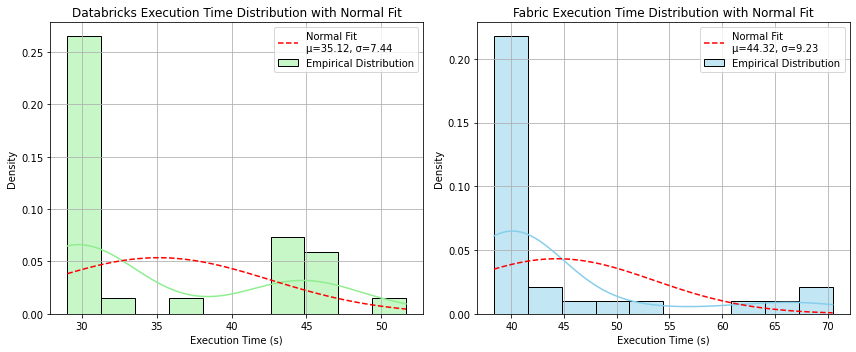

In [19]:
# Extract execution times for Fabric and Databricks
fabric_times = df[df["Environment"] == "Fabric"]["Execution Time (s)"]
databricks_times = df[df["Environment"] == "Databricks"]["Execution Time (s)"]


# Plot distribution with fitted normal for Databricks
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(databricks_times, bins=10, kde=True, stat="density", color="lightgreen", label="Empirical Distribution")
mu_db, std_db = norm.fit(databricks_times)
x_db = np.linspace(databricks_times.min(), databricks_times.max(), 100)
p_db = norm.pdf(x_db, mu_db, std_db)
plt.plot(x_db, p_db, 'r--', label=f'Normal Fit\nμ={mu_db:.2f}, σ={std_db:.2f}')
plt.title("Databricks Execution Time Distribution with Normal Fit")
plt.xlabel("Execution Time (s)")
plt.ylabel("Density")
plt.legend()
plt.grid(True)

# Plot distribution with fitted normal for Fabric
plt.subplot(1, 2, 2)
sns.histplot(fabric_times, bins=10, kde=True, stat="density", color="skyblue", label="Empirical Distribution")
mu_fab, std_fab = norm.fit(fabric_times)
x_fab = np.linspace(fabric_times.min(), fabric_times.max(), 100)
p_fab = norm.pdf(x_fab, mu_fab, std_fab)
plt.plot(x_fab, p_fab, 'r--', label=f'Normal Fit\nμ={mu_fab:.2f}, σ={std_fab:.2f}')
plt.title("Fabric Execution Time Distribution with Normal Fit")
plt.xlabel("Execution Time (s)")
plt.ylabel("Density")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [16]:
# Assuming df is already loaded and processed as shown earlier

test_results = []
for day in df["Date"].unique():
    group_databricks = df[(df["Date"] == day) & (df["Environment"] == "Databricks")]["Execution Time (s)"]
    group_fabric = df[(df["Date"] == day) & (df["Environment"] == "Fabric")]["Execution Time (s)"]
    
    u_stat, p_value = mannwhitneyu(group_databricks, group_fabric, alternative='two-sided')
    test_results.append({
        "Date": day,
        "U Statistic": u_stat,
        "p-value": p_value,
        "Databricks Median": group_databricks.median(),
        "Fabric Median": group_fabric.median()
    })

results_df = pd.DataFrame(test_results)
display(results_df)

,Date,U Statistic,p-value,Databricks Median,Fabric Median
0,May 5,80.0,0.025692,44.850,40.060
1,May 6,0.0,0.000182,29.755,39.565
2,May 11,0.0,0.000182,29.380,40.630


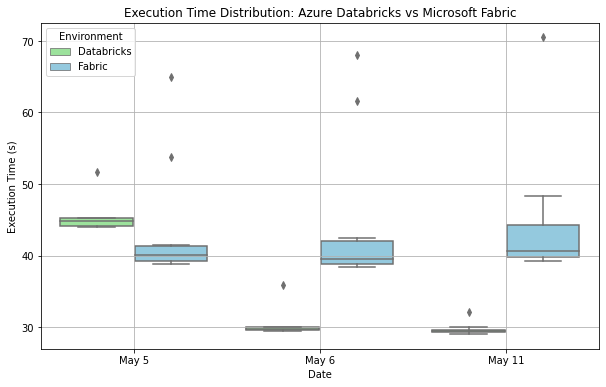

In [17]:
# Define custom colors
custom_palette = {
    "Databricks": "lightgreen",  # match distribution plot for Databricks
    "Fabric": "skyblue"          # match distribution plot for Fabric
}

plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x="Date", y="Execution Time (s)", hue="Environment", palette=custom_palette)
plt.title("Execution Time Distribution: Azure Databricks vs Microsoft Fabric")
plt.grid(True)
plt.show()


In [18]:


summary = df.groupby(["Environment", "Date"])["Execution Time (s)"].agg(["mean", "min", "max", "std"]).reset_index()
summary



,Environment,Date,mean,min,max,std
0,Databricks,May 11,29.661,29.03,32.05,0.881860
1,Databricks,May 5,45.361,44.02,51.66,2.270861
2,Databricks,May 6,30.345,29.40,35.87,1.953119
3,Fabric,May 11,44.528,39.26,70.49,9.568024
4,Fabric,May 5,43.771,38.85,64.98,8.673421
5,Fabric,May 6,44.661,38.35,68.08,10.813046
